In [3]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

In [25]:
import ta
import yfinance as yf
import numpy as np
import pandas as pd
import joblib
from joblib import Parallel, delayed
from pathlib import Path
import matplotlib.pyplot as plt

# Download historical price data for a stock
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 
           'BA', 'XOM', 'ORCL', 'META', 'BRK', 'GS', 'HSBC', 'MS', 'PYPL', 'BAC', 'BLK']
print(len(tickers))
df = [yf.download(ticker, start="2014-11-01", end="2024-11-01") for ticker in tickers]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

26



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days and Bollinger Bands')

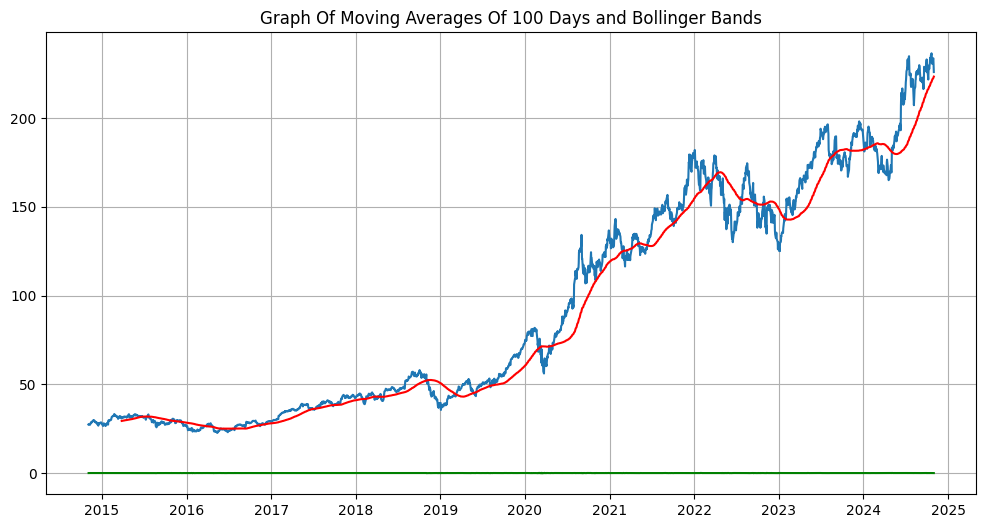

In [27]:
aapl_close = df[0]["Close"].squeeze() 
ma100 = aapl_close.rolling(100).mean()

BB = ta.volatility.BollingerBands(aapl_close, window=20)
high_band = BB.bollinger_hband()
low_band = BB.bollinger_lband()
    
plt.figure(figsize = (12,6))
plt.plot(aapl_close)
plt.plot(high_band, 'b')
plt.plot(low_band, 'b')
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('Graph Of Moving Averages Of 100 Days and Bollinger Bands')

In [29]:
def process_stock(stock_data):
    """
    Process a single stock's data to calculate technical indicators
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock data with High, Low, Close columns
        
    Returns:
        tuple: (processed DataFrame, processed values as float32 array)
    """
    # Extract price series
    close_prices = stock_data["Close"].squeeze()
    high_prices = stock_data["High"].squeeze()
    low_prices = stock_data["Low"].squeeze()
    volumes = stock_data["Volume"].squeeze()
    
    # Create a copy to avoid modifying the original
    df_processed = stock_data.copy()
    
    # Calculate momentum indicators
    df_processed["RSI"] = ta.momentum.rsi(close_prices, window=14)
    df_processed["WR"] = ta.momentum.WilliamsRIndicator(high_prices, low_prices, close_prices).williams_r()
    df_processed['Price Momentum'] = close_prices.pct_change() #Series of positive or negative percentage changes can indicate upward or downward trends
    df_processed['Volume Momentum'] = volumes.pct_change()
    
    #Rolling standard deviation 20
    df_processed['SD20'] = close_prices.rolling(window=20).std()
    
    # Calculate moving averages
    df_processed["SMA7"] = close_prices.rolling(window=7).mean()
    df_processed["SMA14"] = close_prices.rolling(window=14).mean()
    df_processed["SMA21"] = close_prices.rolling(window=21).mean()
    
    # Calculate exponential moving averages
    df_processed['EMA7'] = ta.trend.ema_indicator(close_prices, window=7)
    df_processed['EMA25'] = ta.trend.ema_indicator(close_prices, window=25)
    df_processed['EMA99'] = ta.trend.ema_indicator(close_prices, window=99)
    df_processed['EMA200'] = ta.trend.ema_indicator(close_prices, window=200)
    
    # Calculate trend indicators
    df_processed["MACD"] = ta.trend.MACD(close_prices, window_slow=26, window_fast=12, window_sign=9).macd()
    df_processed["CCI"] = ta.trend.CCIIndicator(close_prices, high_prices, low_prices).cci()
    
    # Calculate volatility indicators
    BB = ta.volatility.BollingerBands(close_prices, window=20)
    df_processed["Upper Band"] = BB.bollinger_hband()
    df_processed["Lower Band"] = BB.bollinger_lband()
    df_processed["Ulcer Index"] = ta.volatility.UlcerIndex(close_prices).ulcer_index()
    
    # Prediction data
    df_processed["Close Next Day"] = close_prices.shift(-1).ffill(limit=2)
    
    # Clean and prepare final data
    df_processed.dropna(inplace=True)
    
    # Convert to float32 array
    values = df_processed.values.astype("float32")
    
    return df_processed, values

def process_all_stocks(df):
    """
    Process all stocks in parallel
    
    Args:
        df (list): List of DataFrames containing stock data
        
    Returns:
        tuple: (list of processed DataFrames, list of processed numpy arrays)
    """
    # Process all stocks in parallel
    results = Parallel(n_jobs=-1)(delayed(process_stock)(stock) for stock in df)
    
    # Unzip the results into separate lists
    processed_dfs, values_list = zip(*results)
    
    return list(processed_dfs), list(values_list)

processed_dfs, values_list = process_all_stocks(df)

In [30]:
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,Price Momentum,Volume Momentum,...,EMA7,EMA25,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-19 00:00:00+00:00,25.937439,28.752501,29.129999,28.670000,29.025000,193146000,38.868505,-58.647164,-0.012790,0.397151,...,29.011843,29.811806,30.819353,30.361521,-0.639367,-59.662038,31.503682,27.742068,8.949397,28.162500
2015-08-20 00:00:00+00:00,25.405203,28.162500,28.587500,27.907499,28.520000,274006400,34.842467,-76.661486,-0.020520,0.418649,...,28.799508,29.684936,30.766216,30.339640,-0.675706,-101.719165,31.285923,27.647077,8.822285,26.440001
2015-08-21 00:00:00+00:00,23.851337,26.440001,27.975000,26.412500,27.607500,513102000,26.282999,-99.232910,-0.061163,0.872591,...,28.209631,29.435326,30.679692,30.300837,-0.833884,-193.641185,31.323332,27.141168,8.940749,25.780001
2015-08-24 00:00:00+00:00,23.255968,25.780001,27.200001,23.000000,23.717501,648825200,23.863926,-60.271513,-0.024962,0.264515,...,27.602223,29.154147,30.581698,30.255854,-1.000959,-286.791374,31.454101,26.519149,9.012688,25.934999
2015-08-25 00:00:00+00:00,23.395792,25.934999,27.777500,25.875000,27.777500,414406400,25.595895,-58.056453,0.006012,-0.361297,...,27.185417,28.906520,30.488764,30.212860,-1.108087,-175.033141,31.390489,26.091761,9.087065,27.422501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,0.003643,0.247281,...,232.117849,229.678046,219.220789,207.361942,2.040117,34.671127,237.613735,222.507266,1.664750,233.399994
2024-10-28 00:00:00+00:00,233.143494,233.399994,234.729996,232.550003,233.320007,36087100,56.742652,-32.306559,0.008599,-0.069975,...,232.438385,229.964350,219.504373,207.621027,2.033819,76.852796,237.666808,222.494192,1.484857,233.669998


In [10]:
def save_processed_data(processed_dfs, values_list, output_dir='processed_data'):
    """
    Save processed DataFrames list and numpy arrays list to single files
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save list of DataFrames using pickle
    with open(output_path / 'processed_dfs.pkl', 'wb') as f:
        joblib.dump(processed_dfs, f)
    
    # Save numpy arrays
    np_path = output_path / 'values_array.npy'
    np.save(np_path, np.array(values_list))

def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

# Save both lists
save_processed_data(processed_dfs, values_list, 'processed_data')

# Later load them
# loaded_dfs, loaded_values = load_processed_data('processed_data')